<a href="https://colab.research.google.com/github/alimoorreza/cs195-fall24-notes/blob/main/cs195_generative_model_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [ ]:
# download the MNIST datasets
path = '/content/drive/MyDrive/cs195_fall24/generative_model_vae/dataset/'
#transform     = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]) # create a transofrm to apply to each datapoint
transform     = transforms.Compose([transforms.ToTensor()]) # create a transofrm to apply to each datapoint
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

In [ ]:
# create train and test dataloaders
batch_size    = 100
train_loader  = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

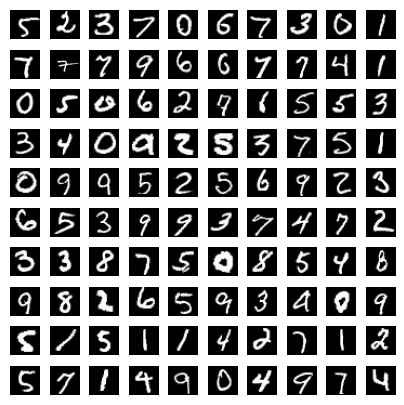

In [ ]:
# get 100 sample training images for visualization
dataiter      = iter(train_loader)
image         = next(dataiter)

num_samples   = 100
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 10), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
def loss_function(x, x_hat, mean, log_var):

    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD               = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

# generating a new sample using the trained VAE model
def generate_digit(mean, var, model):
    #import pdb
    #pdb.set_trace()
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    #digit = x_decoded.detach().cpu().reshape(32, 32) # reshape vector to 2d array
    plt.figure(figsize=(2, 2))
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()



In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer   = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var


def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            import pdb
            pdb.set_trace()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} loss: {overall_loss/(batch_idx*batch_size)}")
    return overall_loss




###__Activity#1: MLP based VAE__
Finish the following tasks:
- VAE network
- train the model
- generate new digit image using the trained model

In [ ]:
# create MLP based VAE
model     = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
train(model, optimizer, epochs=50, device=device)

In [ ]:
# inference: random sample generation using arbitrary mean and variance
generate_digit(0.0, 1.0, model) # mean=0 var=1.0

In [ ]:
# inference: random sample generation using arbitrary mean and variance
generate_digit(1.0, 0.0, model) # mean=1.0, var=0.0

In [ ]:
# inference: random sample generation using a collection of means and variances
def plot_latent_space(model, scale=5.0, n=10, digit_size=28, figsize=10):

    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    counter = 1
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            print(f"{counter}) Generating a new sample digits using mean={xi:.2f} and var={yi:.2f}")
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit
            counter = counter + 1

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [ ]:
plot_latent_space(model, scale=1.0, n=10)

In [ ]:
plot_latent_space(model, scale=5.0, n=10)

###__Activity#2: CNN based VAE__
Finish the following tasks:
- VAE CNN based network
- train the model
- generate new digit image using the trained model

You may find the following modules useful for designing the decoder of VAE:
- [nn.UpsamplingNearest2d](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingNearest2d.html)
  - eg, nn.UpsamplingNearest2d(scale_factor=2.0) will upsample the tensor by a factor of 2.0

- [torch.nn.ConvTranspose2d()](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)
  - eg, nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


- [nn.AdaptiveAvgPool2d()](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)
  - nn.AdaptiveAvgPool2d((28, 28)) creates a fixed size tensor via average pooling operation


In [ ]:

# CNN based VAE
# If you are curious then you can try it

class VAEv2(nn.Module):

    def __init__(self, input_dim=1014, latent_dim=1024, batch_size=100, device=device):
        super(VAEv2, self).__init__()

        self.batch_size = batch_size
        # encoder CNN based
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer   = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder_lin1 = nn.Linear(2, latent_dim)

        self.decoder = nn.Sequential(
            # your code here
            # ...

            )



    def encode(self, x):
        x = self.encoder(x)
        x = x.view(self.batch_size, -1)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon


        return z

    def decode(self, x):

        x      = self.decoder_lin1(x)
        output = x.view(self.batch_size, 64, 4, 4)
        # your code ...
        # ...

        return output


    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var


def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):

            x = x.to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)

            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} loss: {overall_loss/(batch_idx*batch_size)}")
    return overall_loss


# create and train a CNN based VAE
model     = VAEv2().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
train(model, optimizer, epochs=50, device=device)

